## Plotting the ECMWF Forecast Data  
The Ensemble data and the control forecast should be plotted on a local scale (region of southern/ western Germany). Also it should be compared for some single locations. The timeseries shows the evoultion of the forecast for the total precipitation on the 18th of may 2024.

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as crs
import cartopy.feature as cfeature
from shapely import geometry
import pandas as pd
import unittest

## Read all data  
Read in the control forecast data files.

In [2]:
dt13_cf = xr.open_dataset('ESDP_project/netcdf_files/enfo_cf_2024_05_13.nc4')
dt14_cf = xr.open_dataset('ESDP_project/netcdf_files/enfo_cf_2024_05_14.nc4')
dt15_cf = xr.open_dataset('ESDP_project/netcdf_files/enfo_cf_2024_05_15.nc4')
dt16_cf = xr.open_dataset('ESDP_project/netcdf_files/enfo_cf_2024_05_16.nc4')
dt17_cf = xr.open_dataset('ESDP_project/netcdf_files/enfo_cf_2024_05_17.nc4')
dt18_cf = xr.open_dataset('ESDP_project/netcdf_files/enfo_cf_2024_05_18.nc4')

## Functions  
Includes function to extract the data for a specific region and to plot the data for a specific date and time.

In [3]:
def extract_region(dataset, lat_min, lat_max, lon_min, lon_max):
    """
    Extracts data from an xarray Dataset for a specific geographic region.

    Parameters:
    dataset (xarray.Dataset): Input xarray Dataset containing the data.
    lat_min (float): Minimum latitude of the region.
    lat_max (float): Maximum latitude of the region.
    lon_min (float): Minimum longitude of the region.
    lon_max (float): Maximum longitude of the region.

    Returns:
    xarray.Dataset: Subset of the input dataset containing data only for the specified region.
    """
    # Ensure lat_min <= lat_max and lon_min <= lon_max
    lat_min, lat_max = sorted([lat_min, lat_max])
    lon_min, lon_max = sorted([lon_min, lon_max])
    
    # Select latitude and longitude slices based on available dimensions
    if 'latitude' in dataset.dims and 'longitude' in dataset.dims:
        subset = dataset.sel(latitude=(dataset.latitude >= lat_min) & (dataset.latitude <= lat_max), longitude=(dataset.longitude >= lon_min) & (dataset.longitude <= lon_max))
    elif 'lat' in dataset.dims and 'lon' in dataset.dims:
        subset = dataset.sel(lat=(dataset.lat >= lat_min) & (dataset.lat <= lat_max), lon=(dataset.lon >= lon_min) & (dataset.lon <= lon_max))
    else:
        raise ValueError("Latitude or longitude dimensions not found in the dataset.")
    
    return subset

In [4]:
def read_data(dataset):
    '''Read in dataset and return the values of variables total precipitation, lon, lat, time and number (optional)'''

    tp = dataset.tp
    lon = dataset.lon
    lat = dataset.lat
    time = dataset.time
    if any(v is None for v in [tp, lon, lat, time]):
        raise ValueError("Dataset is missing required fields")
    if hasattr(dataset, 'number'):
        number = dataset.number.values
        return tp, lon, lat, time, number
    else:
        return tp, lon, lat, time

In [5]:
def plot_map_tp(dataset, date):
    '''Plot the precipitation for the whole area. Choose one date and all timesteps available from this day will be plotted.'''
    tp, lon, lat, time = read_data(dataset)
    bounds = np.linspace(0, 100, 51)
    
    # Convert time to pandas datetime
    time = pd.to_datetime(time, errors='coerce')  # Coerce invalid dates to NaT
    
    if time.isnull().any():
        raise ValueError("Invalid date format or range")
    
    # Define the times to plot for the specific date (00, 6, 12, 18 hours)
    times_to_plot = pd.to_datetime([
        f"{date}T00:00:00.000000000",
        f"{date}T06:00:00.000000000",
        f"{date}T12:00:00.000000000",
        f"{date}T18:00:00.000000000"
    ])
    
    # Create subplots
    fig, axs = plt.subplots(1, len(times_to_plot), figsize=(16, 6), subplot_kw={'projection': crs.Mercator()})
    contour_plots = []
    for i, t in enumerate(times_to_plot):
        if t in time:
            index = np.where(time == t)[0][0]
            
            ax = axs[i]
            ax.coastlines()
            ax.add_feature(cfeature.BORDERS)
            ax.add_feature(cfeature.RIVERS, color='darkslategrey')
            
            filled_vimd = ax.contourf(lon, lat, tp[index, :, :], levels=bounds, transform=crs.PlateCarree(), cmap='BuPu')
            contour_plots.append(filled_vimd)
            
            title = t.strftime("%d/%m/%Y %H:%M")
            ax.set_title(title)
    
    # Add a single colorbar below all subplots
    cbar_ax = fig.add_axes([0.1, -0.1, 0.8, 0.05])  # [left, bottom, width, height]
    cbar = fig.colorbar(contour_plots[0], cax=cbar_ax, orientation='horizontal', format='%.1f')
    cbar.set_label('[kg/m²]', fontsize=12)
    # Add overall title
    date_first_day = pd.to_datetime(time[0]).strftime("%d/%m/%Y")
    fig.suptitle(f"Forecast of {date_first_day}", fontsize=16)
    
    plt.tight_layout()
    plt.show()
    saveas = pd.to_datetime(time[0]).strftime("%Y_%m_%d")
    plt.savefig(f'forecast_precipitation_map_{saveas}.png')
    plt.close()


## Unittests for the functions

In [10]:
class TestExtractRegion(unittest.TestCase):

    def setUp(self):
        # Setup code, load example dataset for testing
        # Example dataset with 'latitude' and 'longitude'
        self.dataset_with_latlon = xr.Dataset({
            'temperature': (('latitude', 'longitude'), [[10, 20], [30, 40]]),
            'latitude': (['latitude'], [0, 1]),
            'longitude': (['longitude'], [0, 1]),
        })

        # Example dataset with 'lat' and 'lon'
        self.dataset_with_latlon_alt = xr.Dataset({
            'temperature': (('lat', 'lon'), [[10, 20], [30, 40]]),
            'lat': (['lat'], [0, 1]),
            'lon': (['lon'], [0, 1]),
        })

    def test_extract_region_with_latlon(self):
        # Test with valid region boundaries
        lat_min = 0
        lat_max = 1
        lon_min = 0
        lon_max = 1
        result = extract_region(self.dataset_with_latlon, lat_min, lat_max, lon_min, lon_max)
        
        self.assertEqual(result.latitude.values.tolist(), [0, 1])
        self.assertEqual(result.longitude.values.tolist(), [0, 1])
        self.assertEqual(result.temperature.values.tolist(), [[10, 20], [30, 40]])

    def test_extract_region_with_latlon_alt(self):
        # Test with valid region boundaries using alternative dimensions
        lat_min = 0
        lat_max = 1
        lon_min = 0
        lon_max = 1
        result = extract_region(self.dataset_with_latlon_alt, lat_min, lat_max, lon_min, lon_max)
        
        self.assertEqual(result.lat.values.tolist(), [0, 1])
        self.assertEqual(result.lon.values.tolist(), [0, 1])
        self.assertEqual(result.temperature.values.tolist(), [[10, 20], [30, 40]])

    def test_extract_region_out_of_bounds(self):
        # Test with out-of-bounds region boundaries
        lat_min = -1
        lat_max = 2
        lon_min = -1
        lon_max = 2
        result = extract_region(self.dataset_with_latlon, lat_min, lat_max, lon_min, lon_max)
        
        # Check if 'latitude' and 'longitude' are in the resulting dataset
        self.assertIn('latitude', result.coords)
        self.assertIn('longitude', result.coords)
        
        # Check if 'temperature' variable is in the resulting dataset
        self.assertIn('temperature', result.variables)
        
        # Check the values of 'longitude' variable
        if len(result.longitude) > 0:
            expected_lon = [0, 1]
            actual_lon = result['longitude'].values.tolist()
            self.assertEqual(actual_lon, expected_lon)
        else:
            self.fail("No longitude values found in the extracted region.")

In [11]:
class TestReadData(unittest.TestCase):
    def setUp(self):
        # example data for testing
        self.tp = np.random.rand(10)
        self.lon = np.linspace(-180, 180, 10)
        self.lat = np.linspace(-90, 90, 10)
        self.time = np.arange(10)
        self.number = np.random.randint(0, 10, 10)

    def test_read_data_with_number(self):
        # Dataset with 'number'
        dataset = xr.Dataset(
            {
                'tp': (['time'], self.tp),
                'lon': (['time'], self.lon),
                'lat': (['time'], self.lat),
                'time': (['time'], self.time),
                'number': (['time'], self.number)
            }
        )
        
        tp, lon, lat, time, number = read_data(dataset)
        
        np.testing.assert_array_equal(tp, self.tp)
        np.testing.assert_array_equal(lon, self.lon)
        np.testing.assert_array_equal(lat, self.lat)
        np.testing.assert_array_equal(time, self.time)
        np.testing.assert_array_equal(number, self.number)

    def test_read_data_without_number(self):
        # Dataset without 'number'
        dataset = xr.Dataset(
            {
                'tp': (['time'], self.tp),
                'lon': (['time'], self.lon),
                'lat': (['time'], self.lat),
                'time': (['time'], self.time)
            }
        )
        
        tp, lon, lat, time = read_data(dataset)
        
        np.testing.assert_array_equal(tp, self.tp)
        np.testing.assert_array_equal(lon, self.lon)
        np.testing.assert_array_equal(lat, self.lat)
        np.testing.assert_array_equal(time, self.time)

In [12]:
if __name__ == '__main__':
    unittest.main(argv=[''], exit=False)

.....
----------------------------------------------------------------------
Ran 5 tests in 0.088s

OK


unittest for plot_map_tp is missing

## Plot the precipitation forecast  
Plotting the different control forecasts for the 18th of may 2024 for a specific region.

In [6]:
# define a region 
lat_min = 47.
lat_max = 55.
lon_min = 5.
lon_max = 15.5

In [7]:
list_of_files = [dt13_cf, dt14_cf, dt15_cf, dt16_cf, dt17_cf, dt18_cf]
region_data = []
for file in list_of_files:
    extract_datafile = extract_region(file, lat_min, lat_max, lon_min, lon_max)
    region_data.append(extract_datafile)

/opt/tljh/user/envs/py311_esdp/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/opt/tljh/user/envs/py311_esdp/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/opt/tljh/user/envs/py311_esdp/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/opt/tljh/user/envs/py311_esdp/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/tmp/ipykernel_165478/2345342109.py:46: UserWarning:

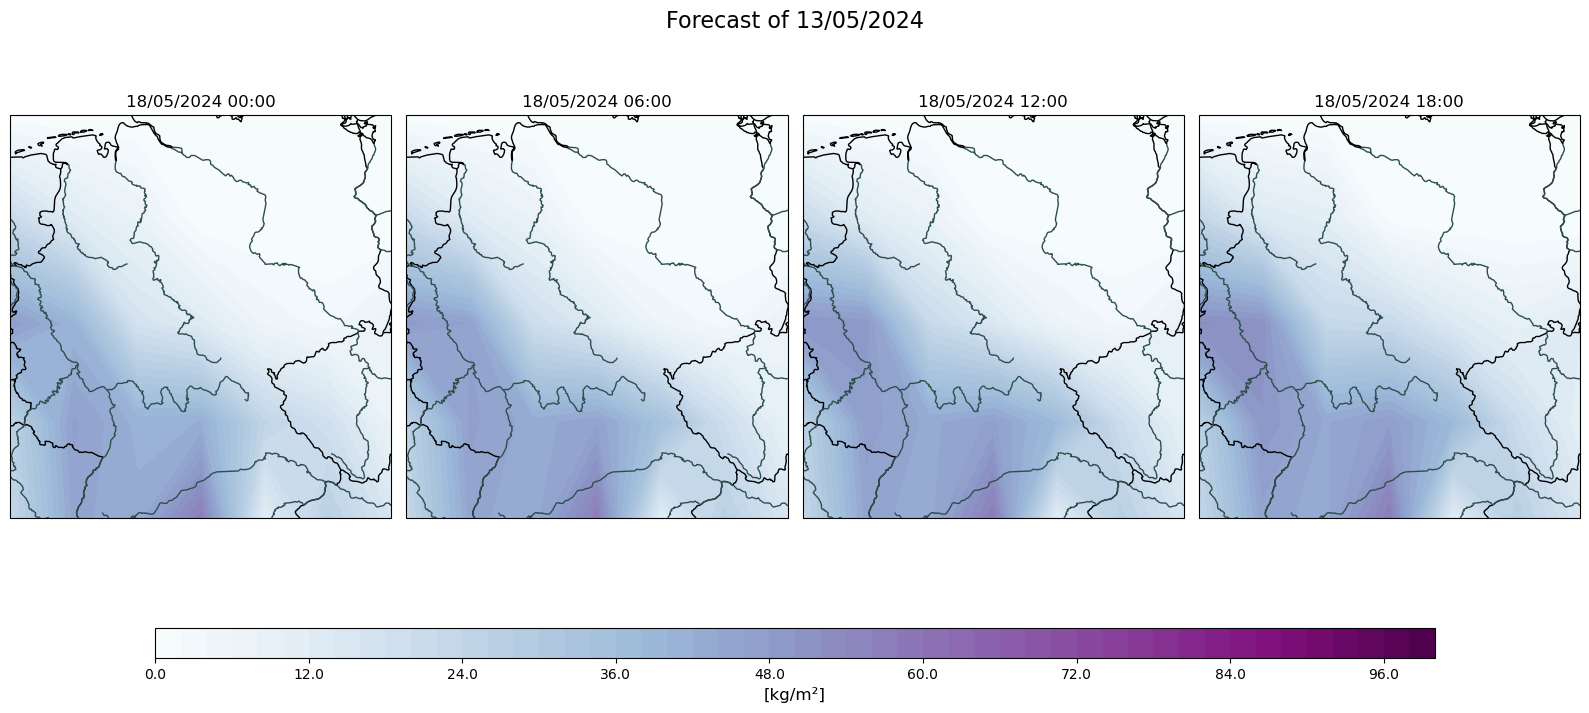

/opt/tljh/user/envs/py311_esdp/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/opt/tljh/user/envs/py311_esdp/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/opt/tljh/user/envs/py311_esdp/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/opt/tljh/user/envs/py311_esdp/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/tmp/ipykernel_165478/2345342109.py:46: UserWarning:

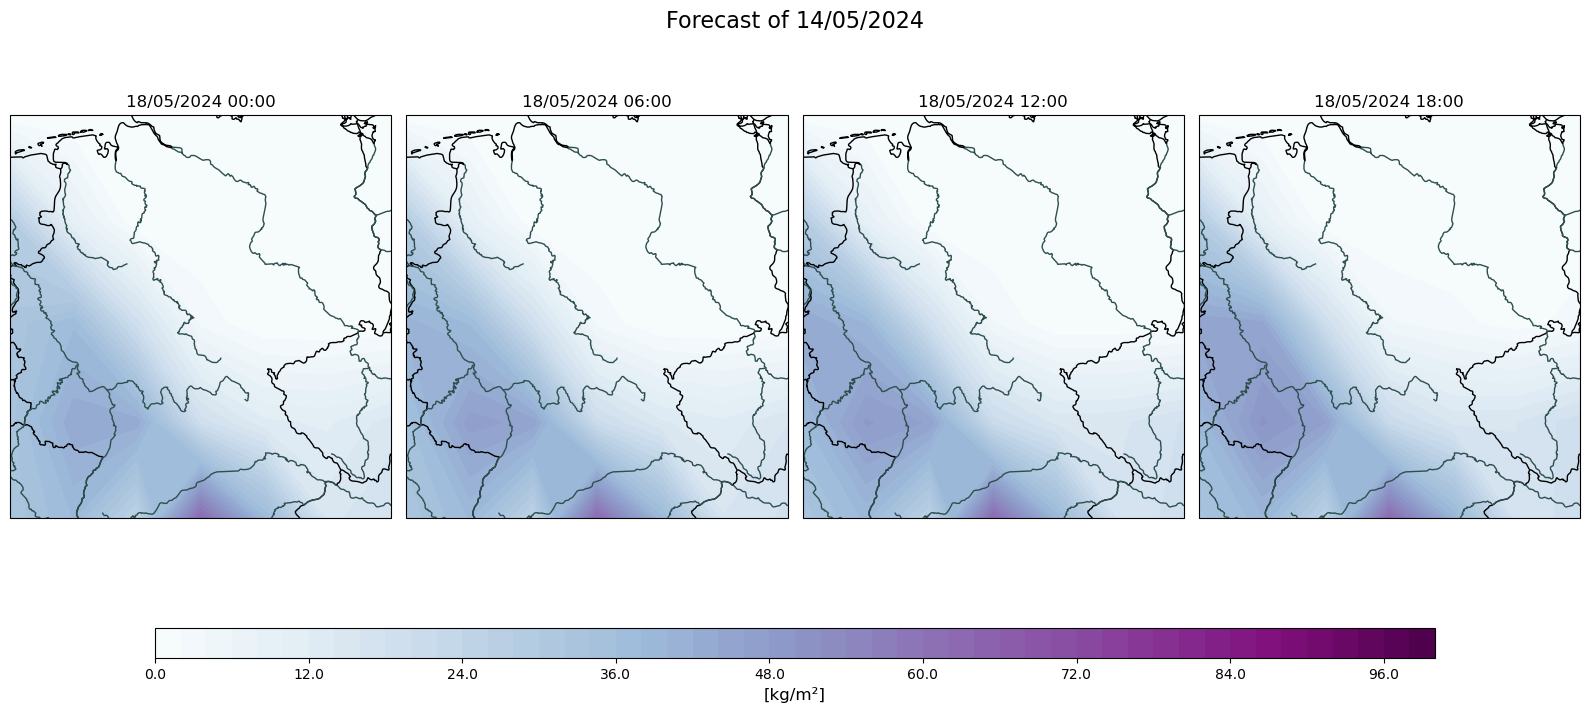

/opt/tljh/user/envs/py311_esdp/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/opt/tljh/user/envs/py311_esdp/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/opt/tljh/user/envs/py311_esdp/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/opt/tljh/user/envs/py311_esdp/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/tmp/ipykernel_165478/2345342109.py:46: UserWarning:

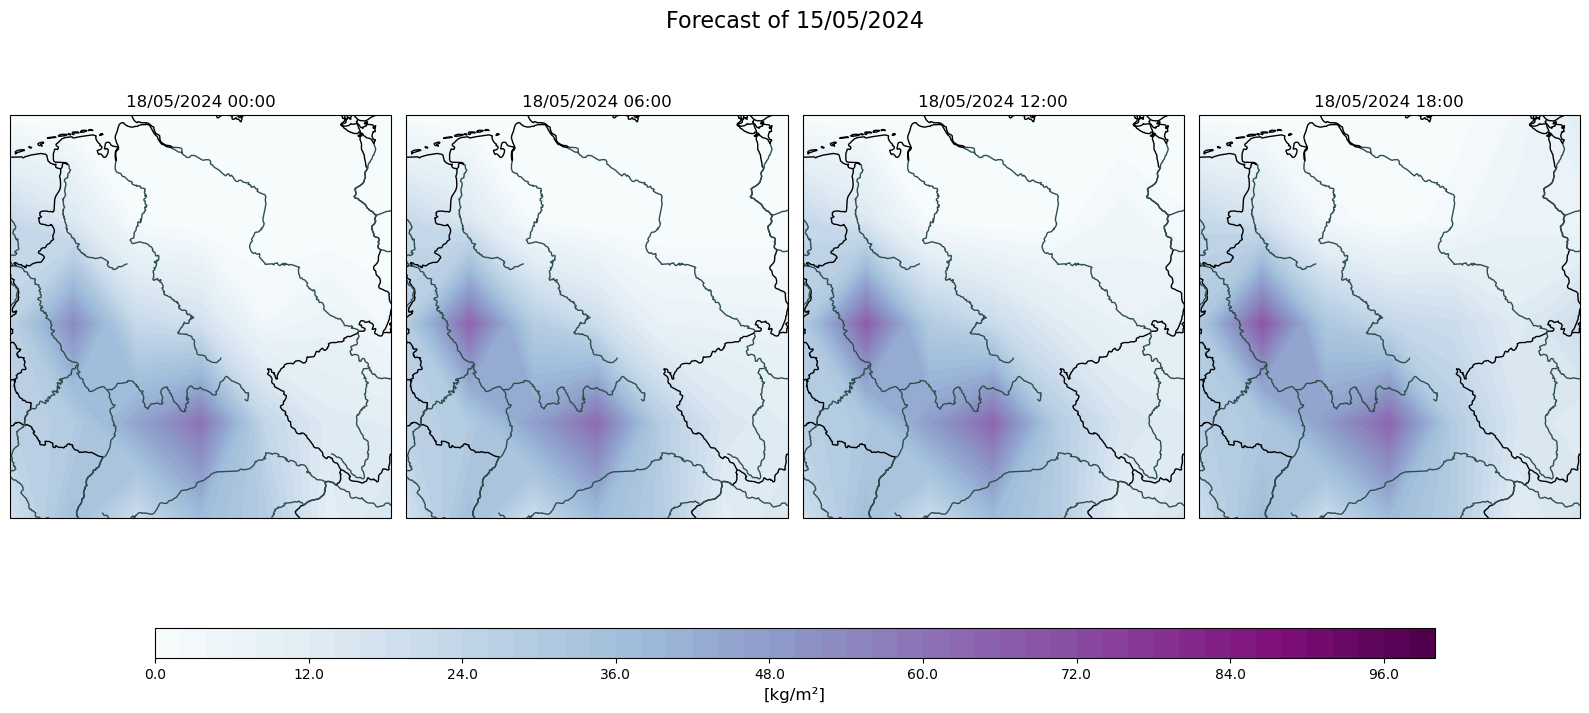

/opt/tljh/user/envs/py311_esdp/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/opt/tljh/user/envs/py311_esdp/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/opt/tljh/user/envs/py311_esdp/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/opt/tljh/user/envs/py311_esdp/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/tmp/ipykernel_165478/2345342109.py:46: UserWarning:

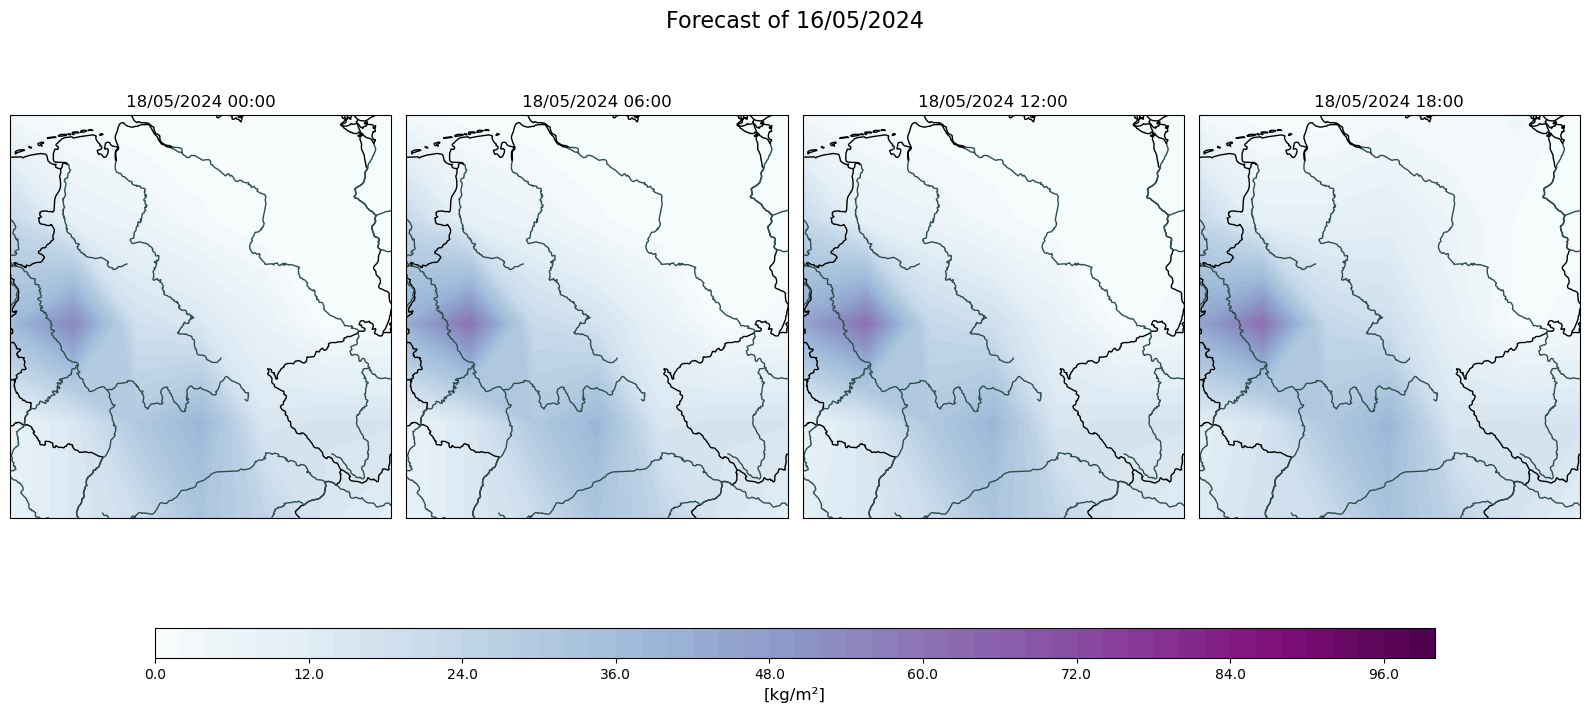

/opt/tljh/user/envs/py311_esdp/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/opt/tljh/user/envs/py311_esdp/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/opt/tljh/user/envs/py311_esdp/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/opt/tljh/user/envs/py311_esdp/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/tmp/ipykernel_165478/2345342109.py:46: UserWarning:

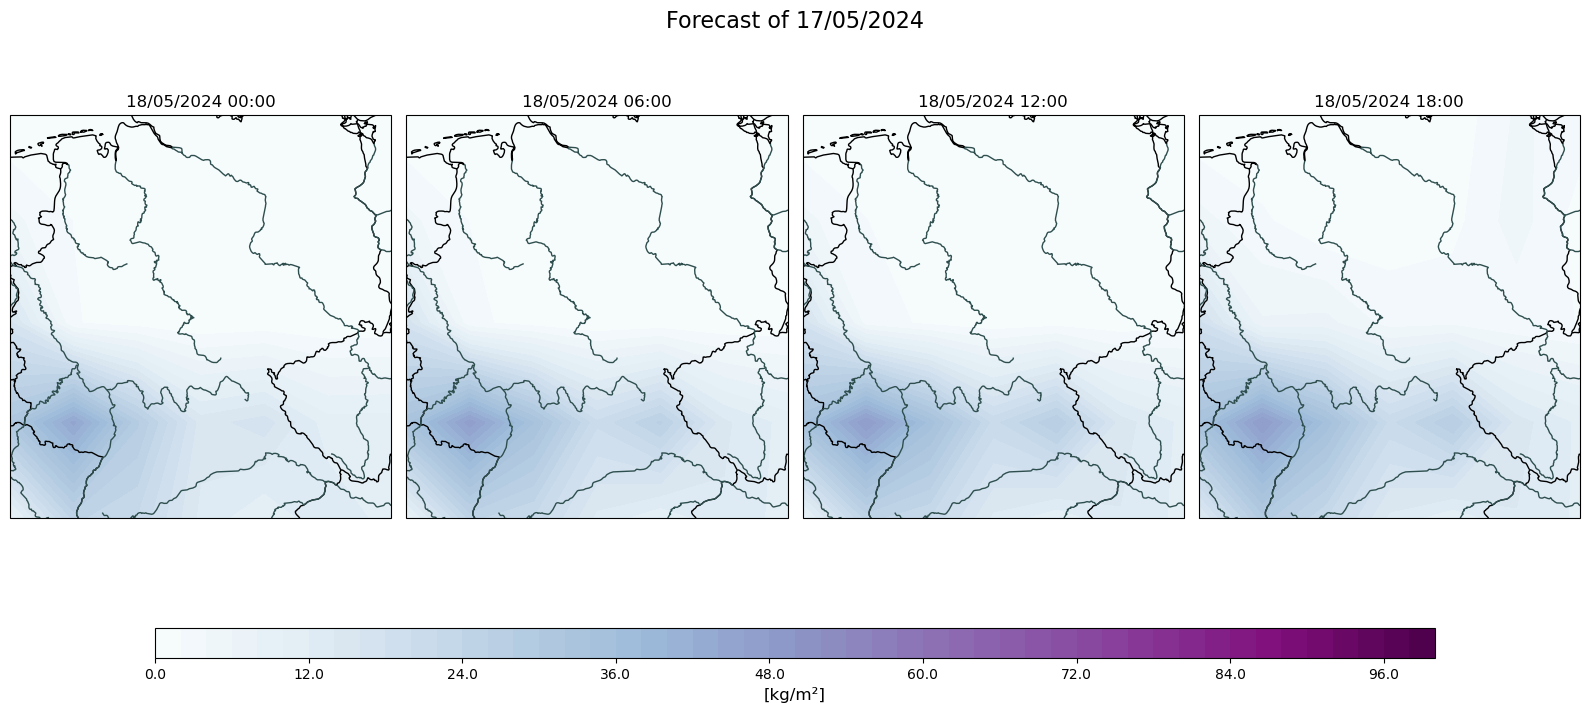

/opt/tljh/user/envs/py311_esdp/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/opt/tljh/user/envs/py311_esdp/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/opt/tljh/user/envs/py311_esdp/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/opt/tljh/user/envs/py311_esdp/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/tmp/ipykernel_165478/2345342109.py:46: UserWarning:

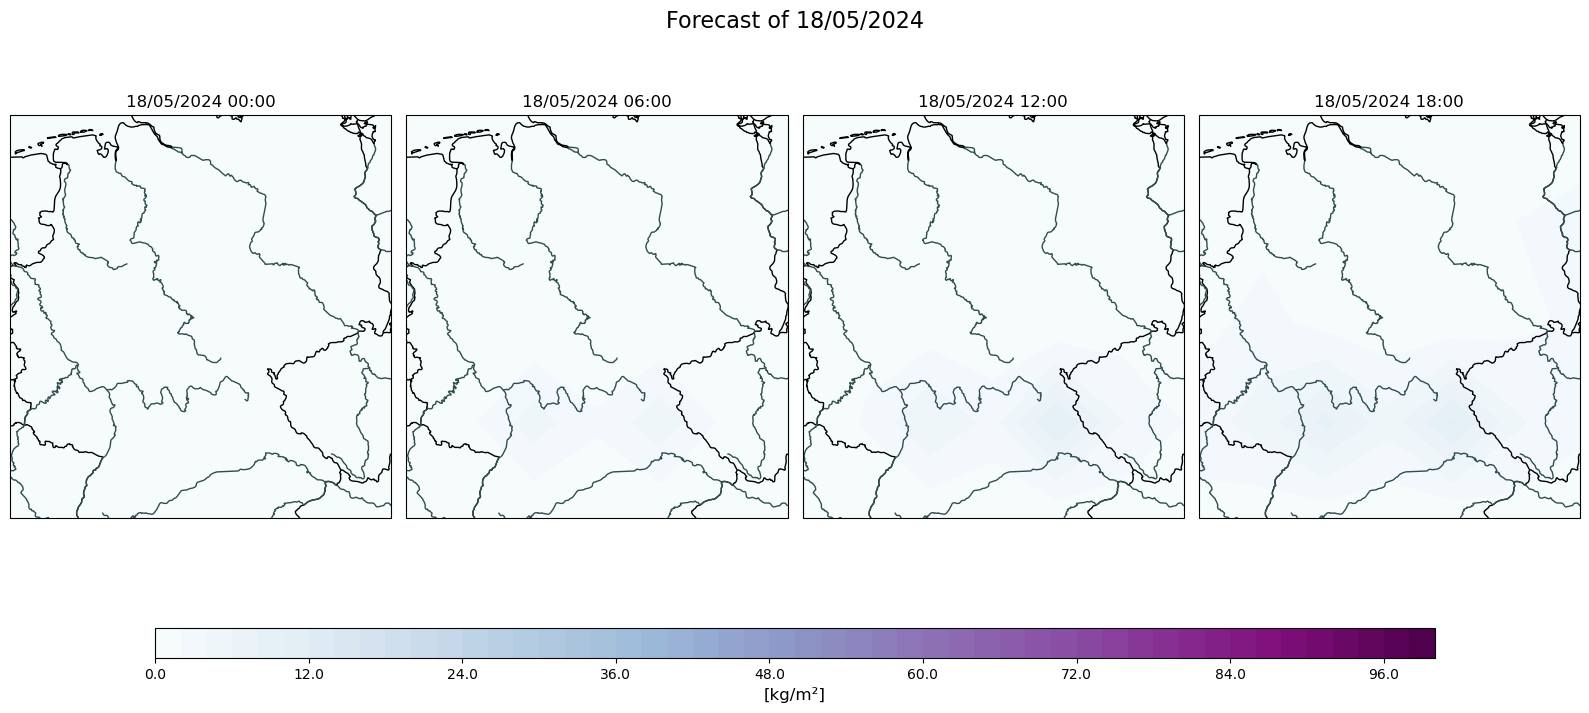

In [8]:
date = '2024-05-18'

for region in region_data:
    plot_map_tp(region, date)